In [34]:
# Importamos librerías necesarias 
import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import date
from datetime import datetime, timedelta
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot

In [3]:
# Ingresamos datos del cliente en Socrata para acceder al dataset de Minsalud
client = Socrata("www.datos.gov.co",
                 "Mj0J5NlKCDgxQtMlVNSei5HLC",
                 username="juliangomez9614@gmail.com",
                 password="Yoyo9614.")

results = client.get("gt2j-8ykr", limit=6000000)


In [4]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results).drop(columns=\
["id_de_caso","fecha_de_notificaci_n", "departamento","ciudad_municipio","unidad_medida",\
"fuente_tipo_contagio","pais_viajo_1_cod","pais_viajo_1_nom",\
"fecha_diagnostico","per_etn_","nom_grupo_","tipo_recuperacion"])

results_df.head()

,fecha_reporte_web,departamento_nom,ciudad_municipio_nom,edad,sexo,ubicacion,estado,recuperado,fecha_inicio_sintomas,fecha_recuperado,fecha_muerte
0,2021-03-04 00:00:00,BOGOTA,BOGOTA,49,M,Casa,Leve,Recuperado,2021-02-25 00:00:00,2021-03-16 00:00:00,NaN
1,2021-03-04 00:00:00,BOGOTA,BOGOTA,49,M,Casa,Leve,Recuperado,2021-02-23 00:00:00,2021-03-16 00:00:00,NaN
2,2021-03-04 00:00:00,BOGOTA,BOGOTA,51,F,Casa,Leve,Recuperado,2021-02-24 00:00:00,2021-03-16 00:00:00,NaN
3,2021-03-04 00:00:00,BOGOTA,BOGOTA,51,F,Casa,Leve,Recuperado,2021-02-27 00:00:00,2021-03-13 00:00:00,NaN
4,2021-03-04 00:00:00,BOGOTA,BOGOTA,51,F,Casa,Leve,Recuperado,2021-03-01 00:00:00,2021-03-16 00:00:00,NaN


In [5]:
#%% DICT Departamentos y población
raw_dpto = {"departamento_nom": ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTA',
       'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA',
       'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'GUAINIA', 'GUAJIRA',
       'GUAVIARE', 'HUILA', 'MAGDALENA', 'META', 'NARIÑO',
       'NORTE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA',
       'SAN ANDRES', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE',
       'VAUPES', 'VICHADA'], "poblacion"\
            :[80464, 6782584,301270,2771139,7834167,2213061,1251675,1027314,414841,439238,1504044,1322466,
             549225,1844076,3372221,51450,987781,88490,1131934,1449087,1072412,1627386,1642746,364085,562117,
             968626,64672,2306455,962457 ,1343898, 4556752, 46808, 114557
]}

In [6]:
#%% Dataframe                                     
dpto_poblaciones = pd.DataFrame(raw_dpto, columns=["departamento_nom", "poblacion"])
dpto_poblaciones.head()

,departamento_nom,poblacion
0,AMAZONAS,80464
1,ANTIOQUIA,6782584
2,ARAUCA,301270
3,ATLANTICO,2771139
4,BOGOTA,7834167


In [7]:
#%% Cambios formato de columnas con fechas
results_df["fecha_reporte_web"] = pd.to_datetime(results_df["fecha_reporte_web"], format="%Y/%m/%d %H:%M:%S")
results_df["fecha_inicio_sintomas"] = pd.to_datetime(results_df["fecha_inicio_sintomas"], format="%Y/%m/%d %H:%M:%S")
results_df["fecha_recuperado"] = pd.to_datetime(results_df["fecha_recuperado"], format="%Y/%m/%d %H:%M:%S")
results_df["fecha_muerte"] = pd.to_datetime(results_df["fecha_muerte"], format="%Y/%m/%d %H:%M:%S")
results_df["edad"] = results_df["edad"].astype("int")


In [37]:
#%% Replace distritos a departamentos 
results_df["recuperado"].replace({"fallecido":"Fallecido"}, inplace=True)
results_df["departamento_nom"].replace({"BARRANQUILLA":"ATLANTICO","CARTAGENA":"BOLIVAR",\
"STA MARTA D.E.":"MAGDALENA","Caldas":"CALDAS","Tolima":"TOLIMA"}, inplace=True)
results_df["sexo"].replace({"f":"F","m":"M"},inplace=True)

In [38]:
#%% Importación desde excel
#Importamos tabla de excel con poblaciones de los departamentos
Poblaciones = pd.read_excel("C:/Users/JulianG/Documents/Covid19/Poblaciones/edades.xlsx", sheet_name=0)
excel_diario = pd.read_excel("C:/Users/JulianG/Documents/Covid19/Diarios col + LATAM.xlsx", sheet_name=0, skipfooter=38, usecols=("A:Q"))

#%% Creamos dataframe de casos sintomáticos y agrupamos por FIS
sintomaticos = results_df.loc[~results_df["fecha_inicio_sintomas"].isnull()]
sintomaticos = sintomaticos.groupby("fecha_inicio_sintomas")["edad"].count().reset_index()
sintomaticos.rename(columns={"edad":"sintomaticos"}, inplace=True)
sintomaticos["Prom móvil 7d"] = sintomaticos.rolling(window=7).mean()
sintomaticos["tasa_de_cambio"] = sintomaticos["Prom móvil 7d"] - sintomaticos["Prom móvil 7d"].shift(1)
sintomaticos["tcambio_pm"] = sintomaticos["tasa_de_cambio"].rolling(window=7).mean()

In [11]:
#%% Organizamos dato de fallecidos
# Agrupar fallecidos por fecha_reporte_web
fallecidos = results_df.loc[results_df["recuperado"] == "Fallecido"]
# Subset por estado según columna recuperación del df original
fallecidos_tidy = fallecidos.groupby("fecha_reporte_web")["recuperado"].count().reset_index()
fallecidos_tidy.rename(columns={"recuperado":"muertes_dia"}, inplace=True)
fallecidos_tidy["Prom móvil 7d"] = fallecidos_tidy.rolling(window=7).mean()
fallecidos_tidy["tasa_de_cambio"] = fallecidos_tidy["Prom móvil 7d"] - fallecidos_tidy["Prom móvil 7d"].shift(1)
fallecidos_tidy["tcambio_pm"] = fallecidos_tidy["tasa_de_cambio"].rolling(window=7).mean()



In [35]:
#%% Sacamos DataFrame de reportes agrupados por fecha y sexo
reportes = results_df.groupby("fecha_reporte_web")["sexo"].count().reset_index()
reportes = reportes.rename(columns = {"sexo":"casos diarios"})

#creamos media móvil 7d, diferencia de medias moviles y media movil de la media movil
reportes["Prom móvil 7d"] = reportes.rolling(window=7).mean()
reportes["tasa_de_cambio"]= reportes["Prom móvil 7d"] - reportes["Prom móvil 7d"].shift(1)
reportes["tcambio_pm"]= reportes["tasa_de_cambio"].rolling(window=7).mean()

"""en este dataframe separamos fechas para plotear graficas por tiempos específicos
"""
fecha_a_resaltar = pd.to_datetime("2021-01-01")
fecha_incertidumbre = datetime.today() - timedelta(days=15)
post_tercerpico = reportes[(reportes["fecha_reporte_web"] >= fecha_a_resaltar) & (reportes["fecha_reporte_web"] <= fecha_incertidumbre)]
post_fallecidos = fallecidos_tidy[(fallecidos_tidy["fecha_reporte_web"] >= fecha_a_resaltar) & (fallecidos_tidy["fecha_reporte_web"] <= fecha_incertidumbre)]

In [13]:
#%% Analizamos datos sacando nuevos calculos como el promedio móvil y merge con poblaciones de cada departamento

#DataFrame de territorio individual
dpto_df = results_df.loc[results_df["departamento_nom"] == "ANTIOQUIA"] #df cambiante
dpto_df_groupedby = dpto_df.groupby(["fecha_reporte_web", "departamento_nom"])["edad"].count().reset_index()
dpto_df_groupedby["Prom móvil 7d"] = dpto_df_groupedby.rolling(window=7).mean()
dpto_df_groupedby["tasa_de_cambio"]= dpto_df_groupedby["Prom móvil 7d"] - dpto_df_groupedby["Prom móvil 7d"].shift(1)
dpto_df_groupedby["tcambio_pm"]= dpto_df_groupedby["tasa_de_cambio"].rolling(window=7).mean()
#SEGUIMIENTO DIARIO DE CASOS 
seguimiento_diario = results_df.groupby(["departamento_nom","fecha_reporte_web"])["edad"].agg(["count", "mean", "std"])
seguimiento_diario = seguimiento_diario.rename(columns={"count":"Casos_dia","mean":"Promedio_edad","std":"Desv_estandar"}).reset_index()
seguimiento_diario = seguimiento_diario.merge(dpto_poblaciones, how="left") #merge con poblacion de dpto_poblaciones
seguimiento_diario["tasa_millon"] = (seguimiento_diario["Casos_dia"]/seguimiento_diario["poblacion"]*1000000)
seguimiento_diario["tasa_millon_pm"] = seguimiento_diario["tasa_millon"].rolling(window=7).mean()
#SEGUIMIENTO DIARIO DE MUERTES
seguimiento_d_muertes = fallecidos.groupby(["departamento_nom","fecha_reporte_web",])["edad"].agg(["count", "mean", "std"])
seguimiento_d_muertes = seguimiento_d_muertes.rename(columns={"count":"Casos_dia","mean":"Promedio_edad","std":"Desv_estandar"}).reset_index()
seguimiento_d_muertes = seguimiento_d_muertes.merge(dpto_poblaciones, how="left")
seguimiento_d_muertes["tasa_millon"] = (seguimiento_d_muertes["Casos_dia"]/seguimiento_d_muertes["poblacion"]*1000000)
seguimiento_d_muertes["tasa_millon_pm"] = seguimiento_d_muertes["tasa_millon"].rolling(window=7).mean()

post_dpto_df_groupedby = dpto_df_groupedby[(dpto_df_groupedby["fecha_reporte_web"] >= fecha_a_resaltar) & (dpto_df_groupedby["fecha_reporte_web"] <= fecha_incertidumbre)]


In [44]:
#%% Df filtrado por Departamento y asignamos frecuencia diaria para evitar saltos en fechas
highlighted_muerte = seguimiento_d_muertes.query("departamento_nom in ['AMAZONAS']")
highlighted_muerte["tasa_fixed2"] = highlighted_muerte["tasa_millon"].rolling(window=7).mean()

querydp = highlighted_muerte.set_index("fecha_reporte_web")
querydp = querydp.asfreq("D")
querydp["departamento_nom"] = querydp["departamento_nom"].fillna(value="AMAZONAS")
querydp["Casos_dia"] = querydp["Casos_dia"].fillna(value="0").astype("float")
querydp["poblacion"] = querydp["poblacion"].fillna(value="80464").astype("float")
querydp["tasa_millon"] = (querydp["Casos_dia"]/querydp["poblacion"]*1000000)
querydp["tasa_millon_pm"].update(querydp["tasa_millon"].rolling(window=7).mean())
querydp.rename(columns={"Casos_dia":"Muertes_dia"}, inplace=True)

# querydp["tasa_fixed2"] = querydp["tasa_fixed2"].fillna(value="0")
querydp["tasa_fixed2"] = querydp["tasa_millon"].rolling(window=7).mean()

<ipython-input-44-7e5457587285>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highlighted_muerte["tasa_fixed2"] = highlighted_muerte["tasa_millon"].rolling(window=7).mean()


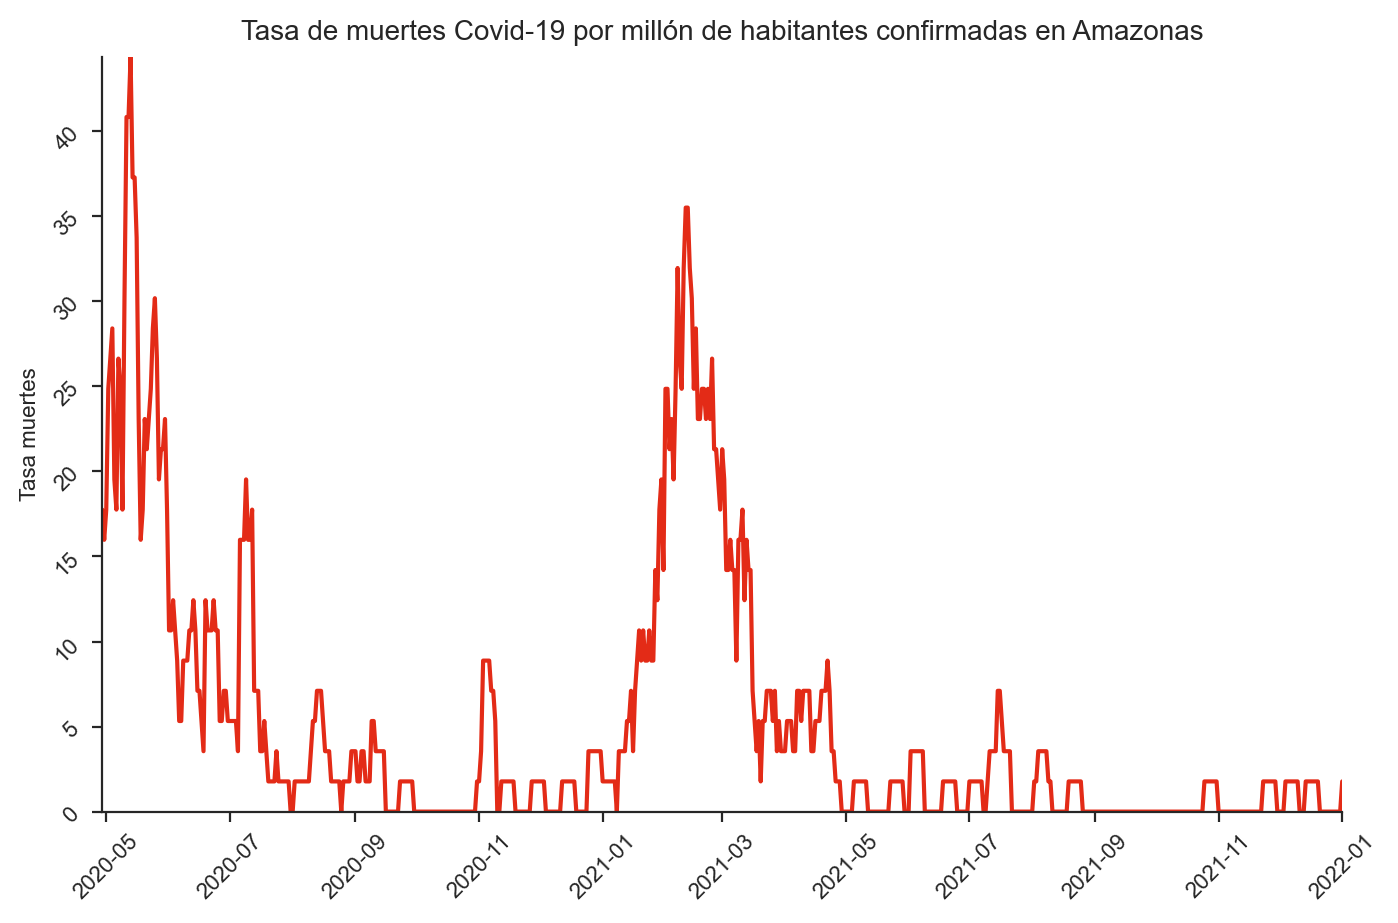

In [48]:
#%% SubPlot de fallecidos por día 
plt.figure(figsize=(8,5), dpi=200)
sns.set_style("ticks")
sns.lineplot(x="fecha_reporte_web", y="tasa_fixed2", data=querydp, color="#e32b17")
plt.title("Tasa de muertes Covid-19 por millón de habitantes confirmadas en Amazonas", fontsize=10)

plt.tick_params(labelsize=8,rotation=45)
plt.ylabel("Tasa muertes", fontsize=8)
plt.xlabel("")
plt.margins(x=0, y=0)
sns.despine(top=True)

plt.show()



In [16]:
#%% Datos concernientes a la edad media fallecidos por sexo
resumen = results_df.loc[results_df["recuperado"] == "Fallecido"]
resumen = resumen.groupby(["fecha_reporte_web","sexo"])["edad"].agg(["count","mean","median","std"]).reset_index()
resumen["media muerte edad pm7d"] = resumen["mean"].rolling(window=7).mean()

#%% PRUEBA: dataframe por departamentos anexando población para sacar tasa
Bogota = results_df.loc[results_df["departamento_nom"] == "BOGOTA"]
Bogota = Bogota.drop(Bogota[Bogota.recuperado == "N/A"].index)

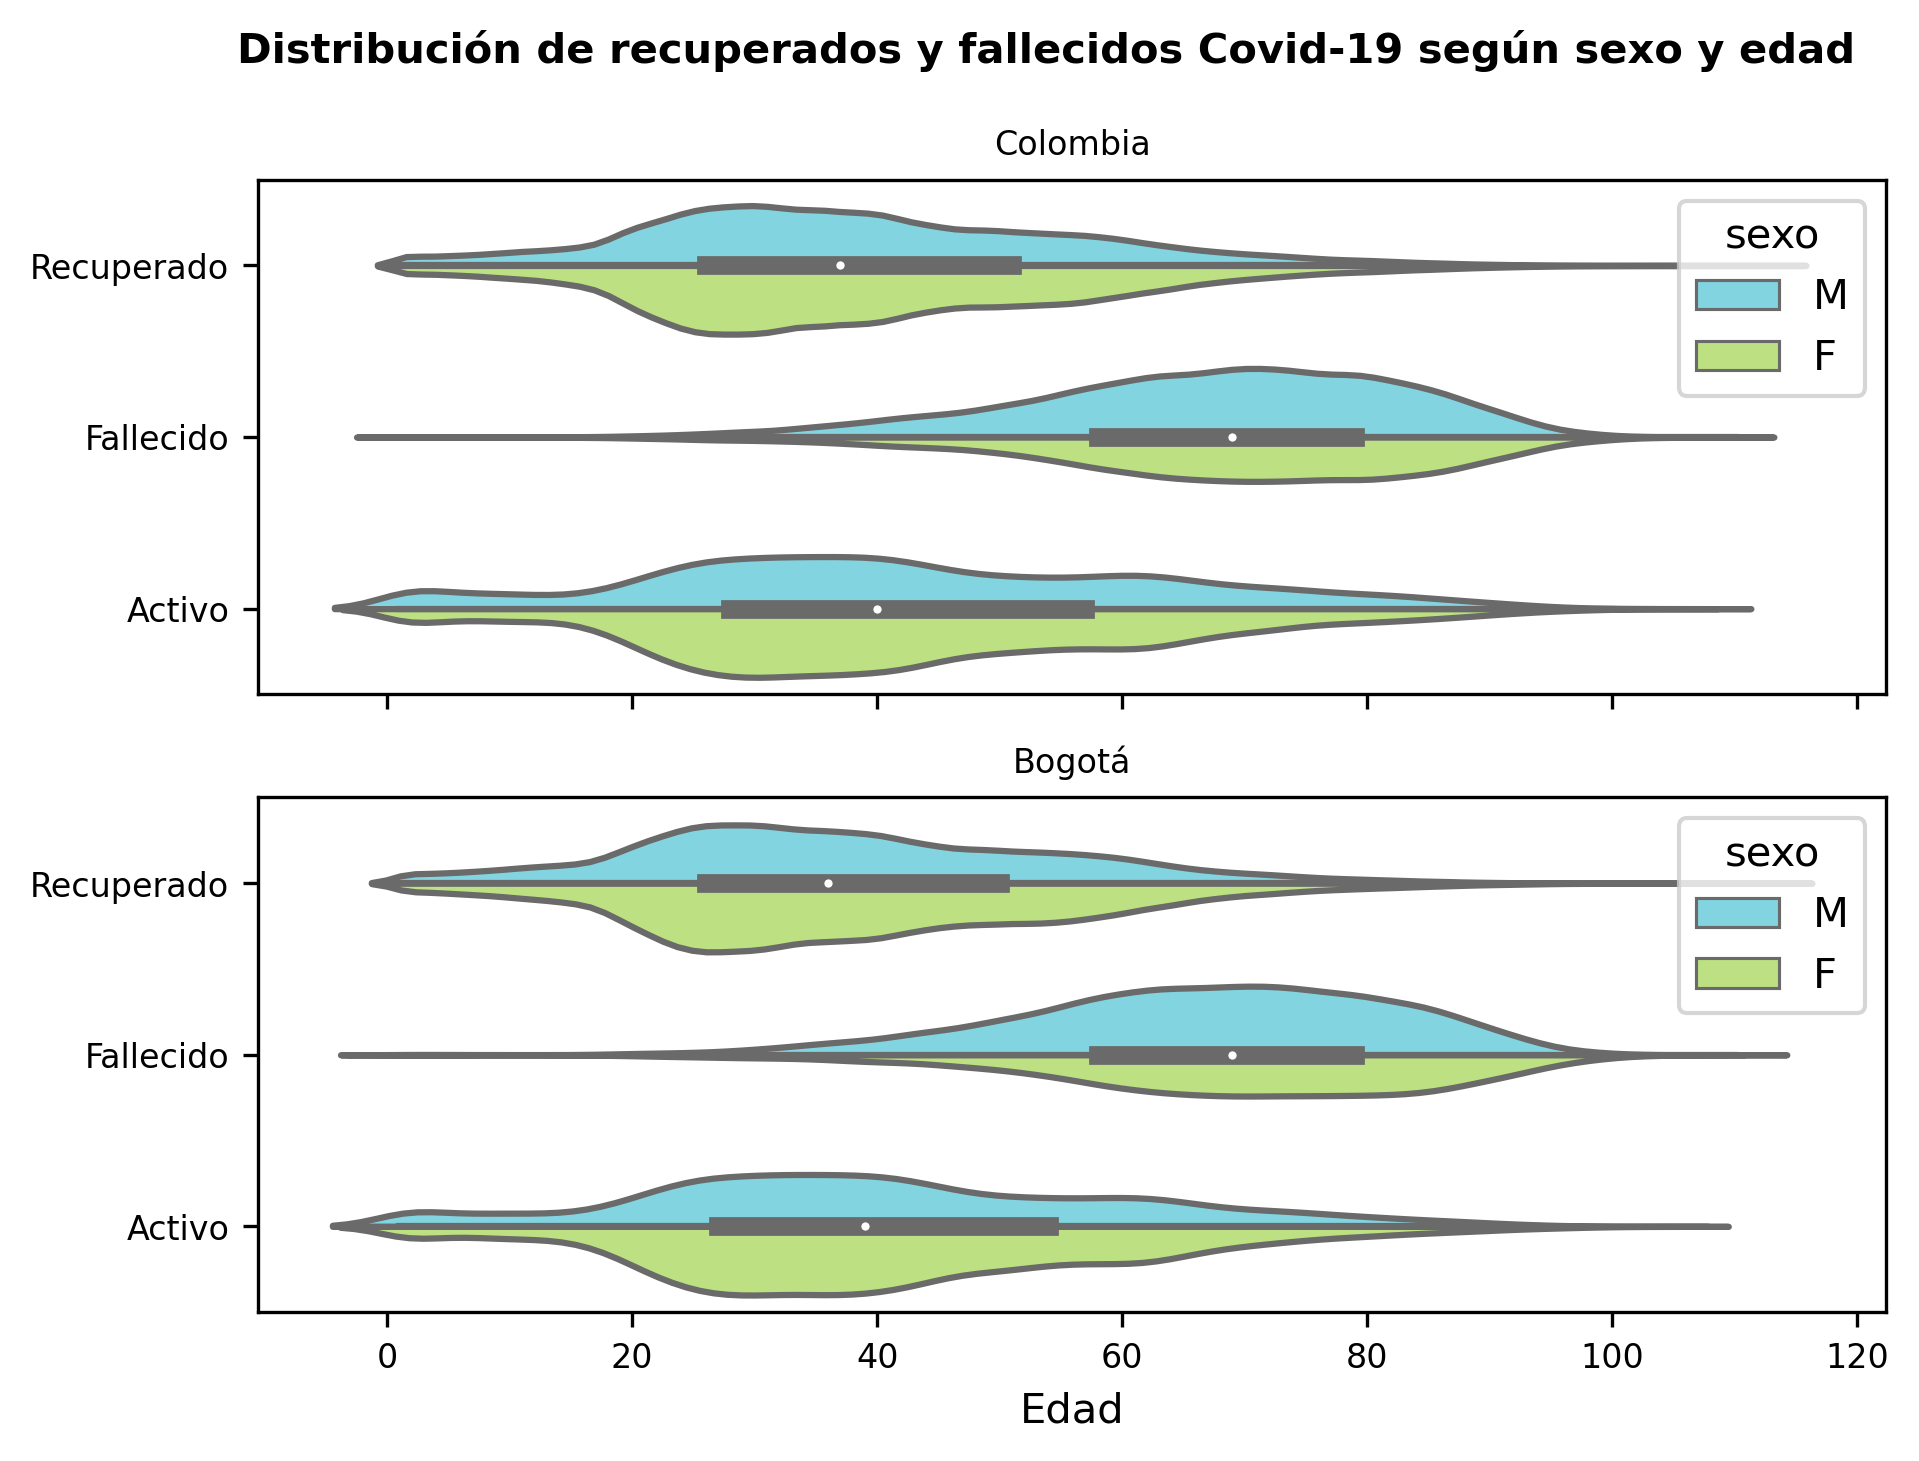

In [17]:
#%% Drop n/a de "recuperado" en nuevo dataframe (no trabajando ahora)
results_nona = results_df.drop(results_df[results_df.recuperado == "N/A"].index)

fig, axes = plt.subplots(2,1, sharex=True, figsize=(7,5), dpi=300)

sns.violinplot(ax=axes[0], x="edad", y="recuperado", data=results_nona, palette={"F":"#C1F172", "M":"#72E0F1"}, linewidth=1.5, hue="sexo", split=True, scale="count")
ax=axes[0].tick_params(labelsize=8,rotation=0)
ax=axes[0].set(xlabel=None, ylabel=None)
ax=axes[0].set_title("Colombia", fontsize=8)
#Violin plot 
sns.violinplot(ax=axes[1], x="edad", y="recuperado", data=Bogota, palette={"F":"#C1F172", "M":"#72E0F1"}, linewidth=1.5, hue="sexo", split=True, scale="count")
ax=axes[1].tick_params(labelsize=8,rotation=0)
ax=axes[1].set_title("Bogotá", fontsize=8)
ax=axes[1].set(xlabel="Edad", ylabel=None)
fig.suptitle("Distribución de recuperados y fallecidos Covid-19 según sexo y edad", fontsize=10, fontweight="bold")
plt.show()

In [18]:
#%% Casos atrasados y activos (posiblemente eliminar porque no se usa)
atrasados = results_df.loc[(results_df["fecha_reporte_web"] == "2021-11-22") & (results_df["fecha_inicio_sintomas"] <= "2021-08-22")]
activos = results_df.loc[results_df["recuperado"] == "Activo"].sort_values(by=["departamento_nom"], ascending=True)
activos_group = activos.groupby("departamento_nom")["sexo"].count().reset_index().sort_values("sexo", ascending=False)
activos_group = activos_group.merge(dpto_poblaciones, how="left")
#Activos por millón de habitantes
activos_group["tasa"] = ((activos_group["sexo"]/activos_group["poblacion"])*1000000)
activos_tasa = activos_group.copy().sort_values("tasa", ascending=False)

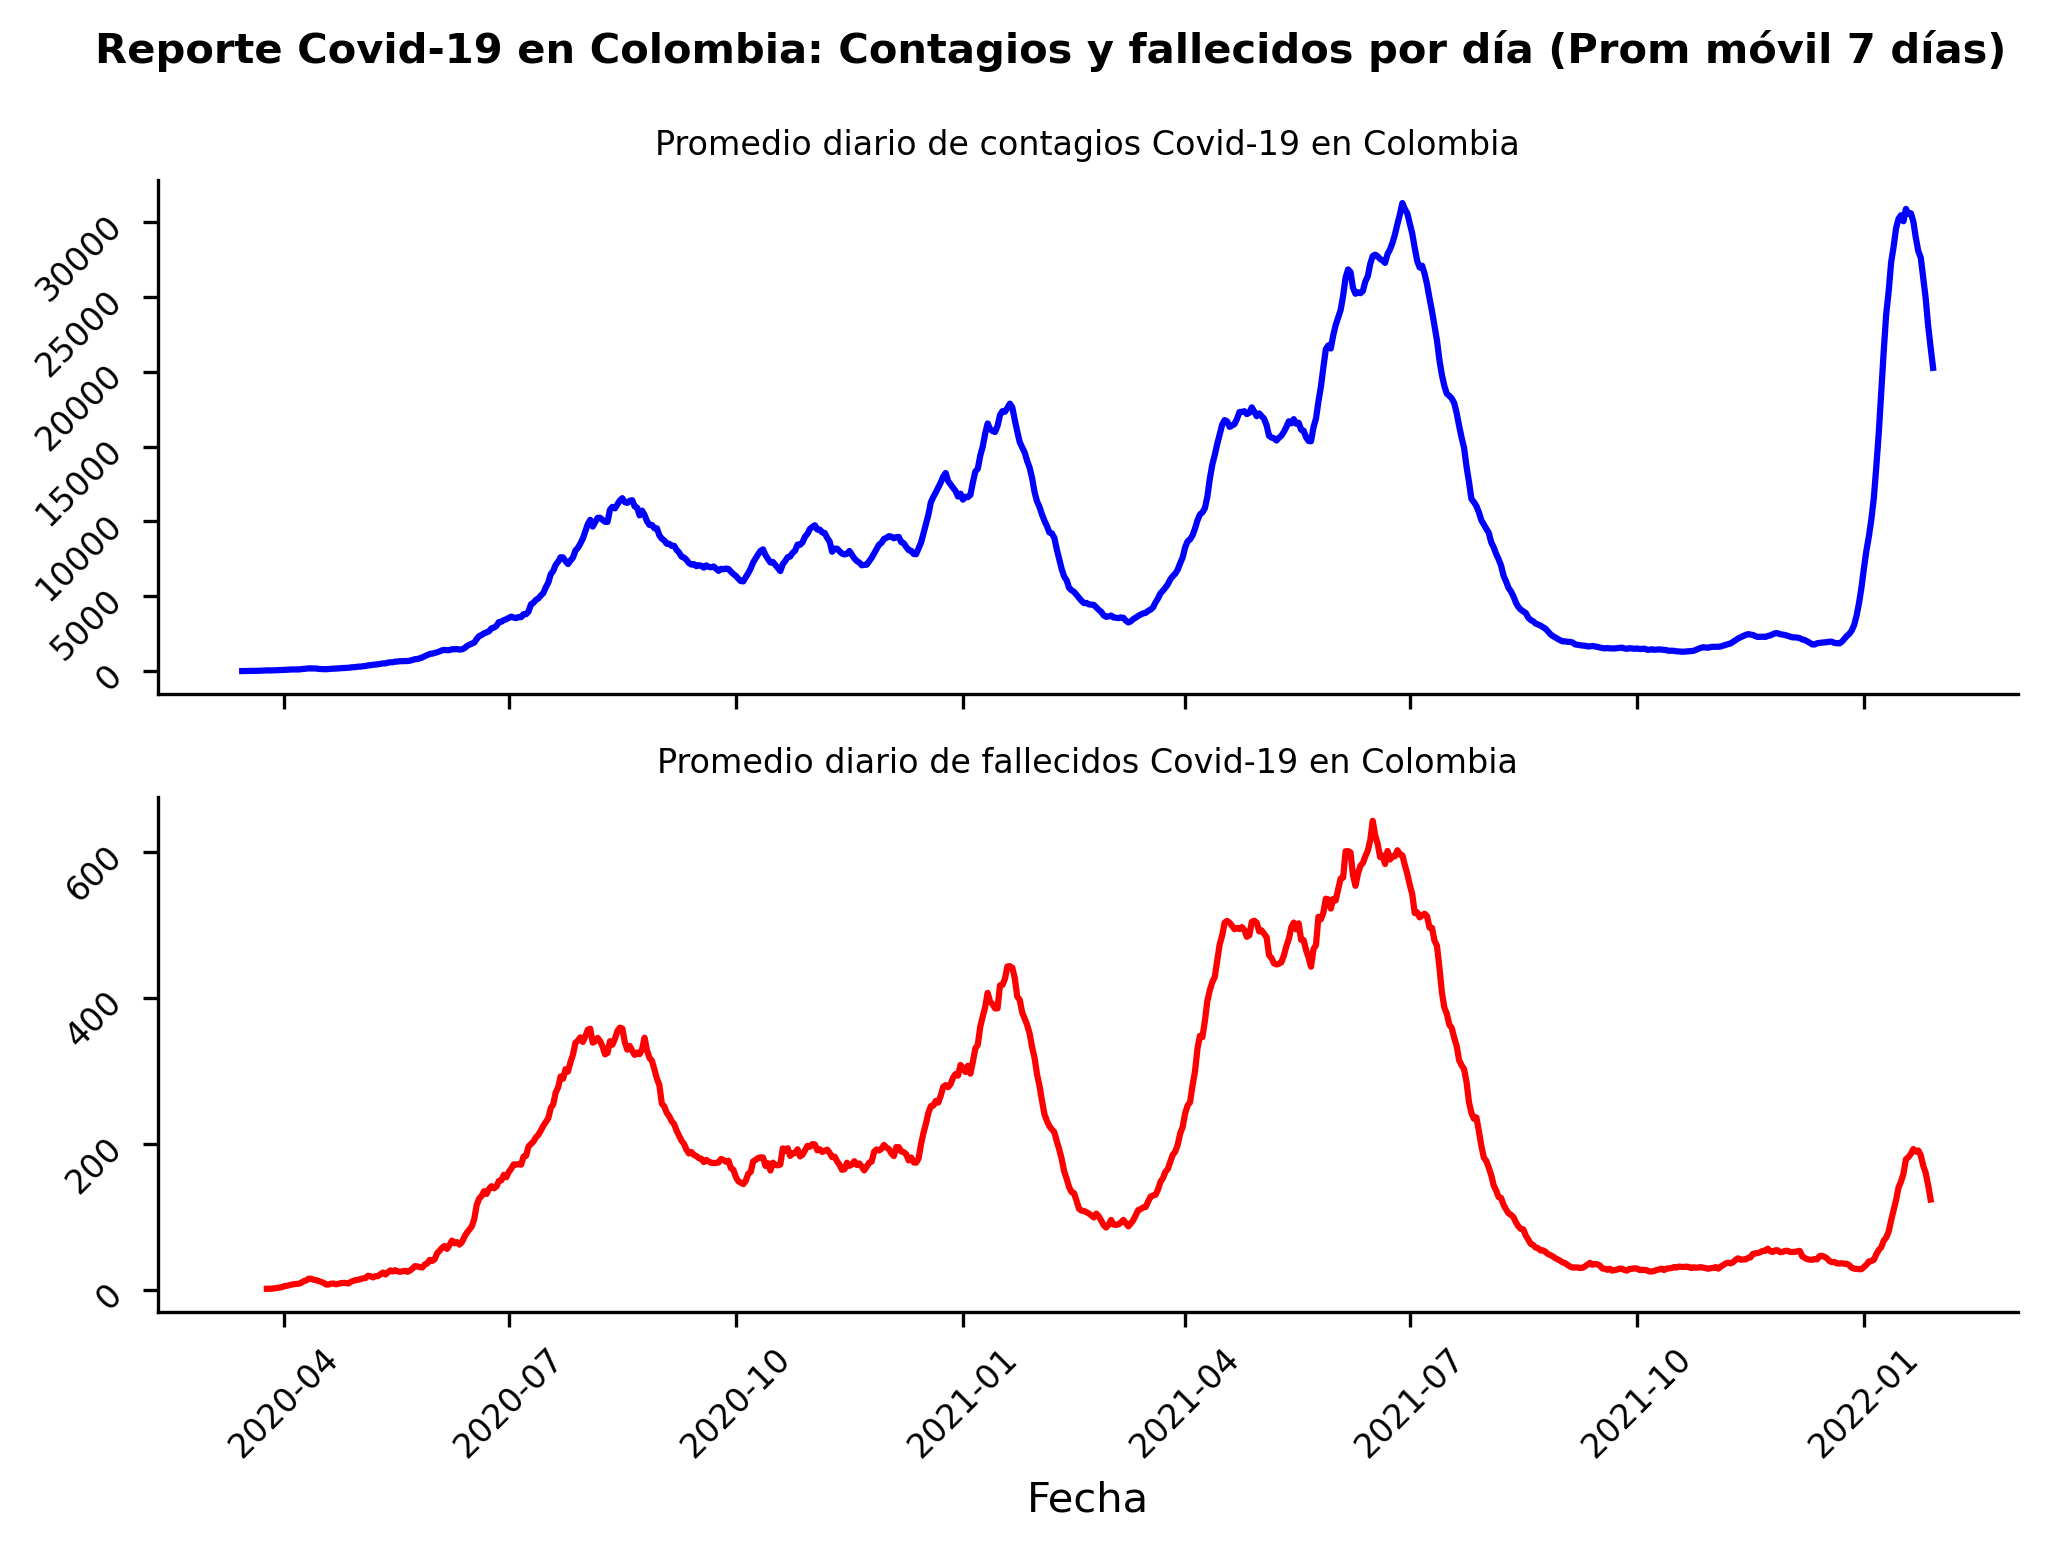

In [19]:
#%% SUBPLOT 1X1 casos y muertes diarias
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5), dpi=300)
fig.suptitle("Reporte Covid-19 en Colombia: Contagios y fallecidos por día (Prom móvil 7 días) ", fontsize=10, fontweight="bold")

sns.lineplot(ax=axs[0], x="fecha_reporte_web", y="Prom móvil 7d", data=reportes, color="b") #cambiamos data con "reportes","dpto_df_groupedby","fallecidos", "sintomaticos"
sns.lineplot(ax=axs[1], x="fecha_reporte_web", y="Prom móvil 7d", data=fallecidos_tidy, color="r") #cambiamos data con "reportes","dpto_df_groupedby","fallecidos"
axs[0].tick_params(labelsize=8,rotation=45)
axs[1].tick_params(labelsize=8,rotation=45)
axs[0].set_title("Promedio diario de contagios Covid-19 en Colombia", fontsize=8)
axs[1].set_title("Promedio diario de fallecidos Covid-19 en Colombia", fontsize=8)
axs[0].set(xlabel=None, ylabel=None)
axs[1].set(xlabel="Fecha", ylabel=None)
#axs[0].axhline(2649, ls="--", color="#9B9397", linewidth=.7) #horizontal line promedio actual de fallecidos
#axs[1].axhline(45, ls="--", color="#9B9397", linewidth=.7) #horizontal line promedio actual de fallecidos
axs[0].spines['top'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['right'].set_visible(False)
plt.show()


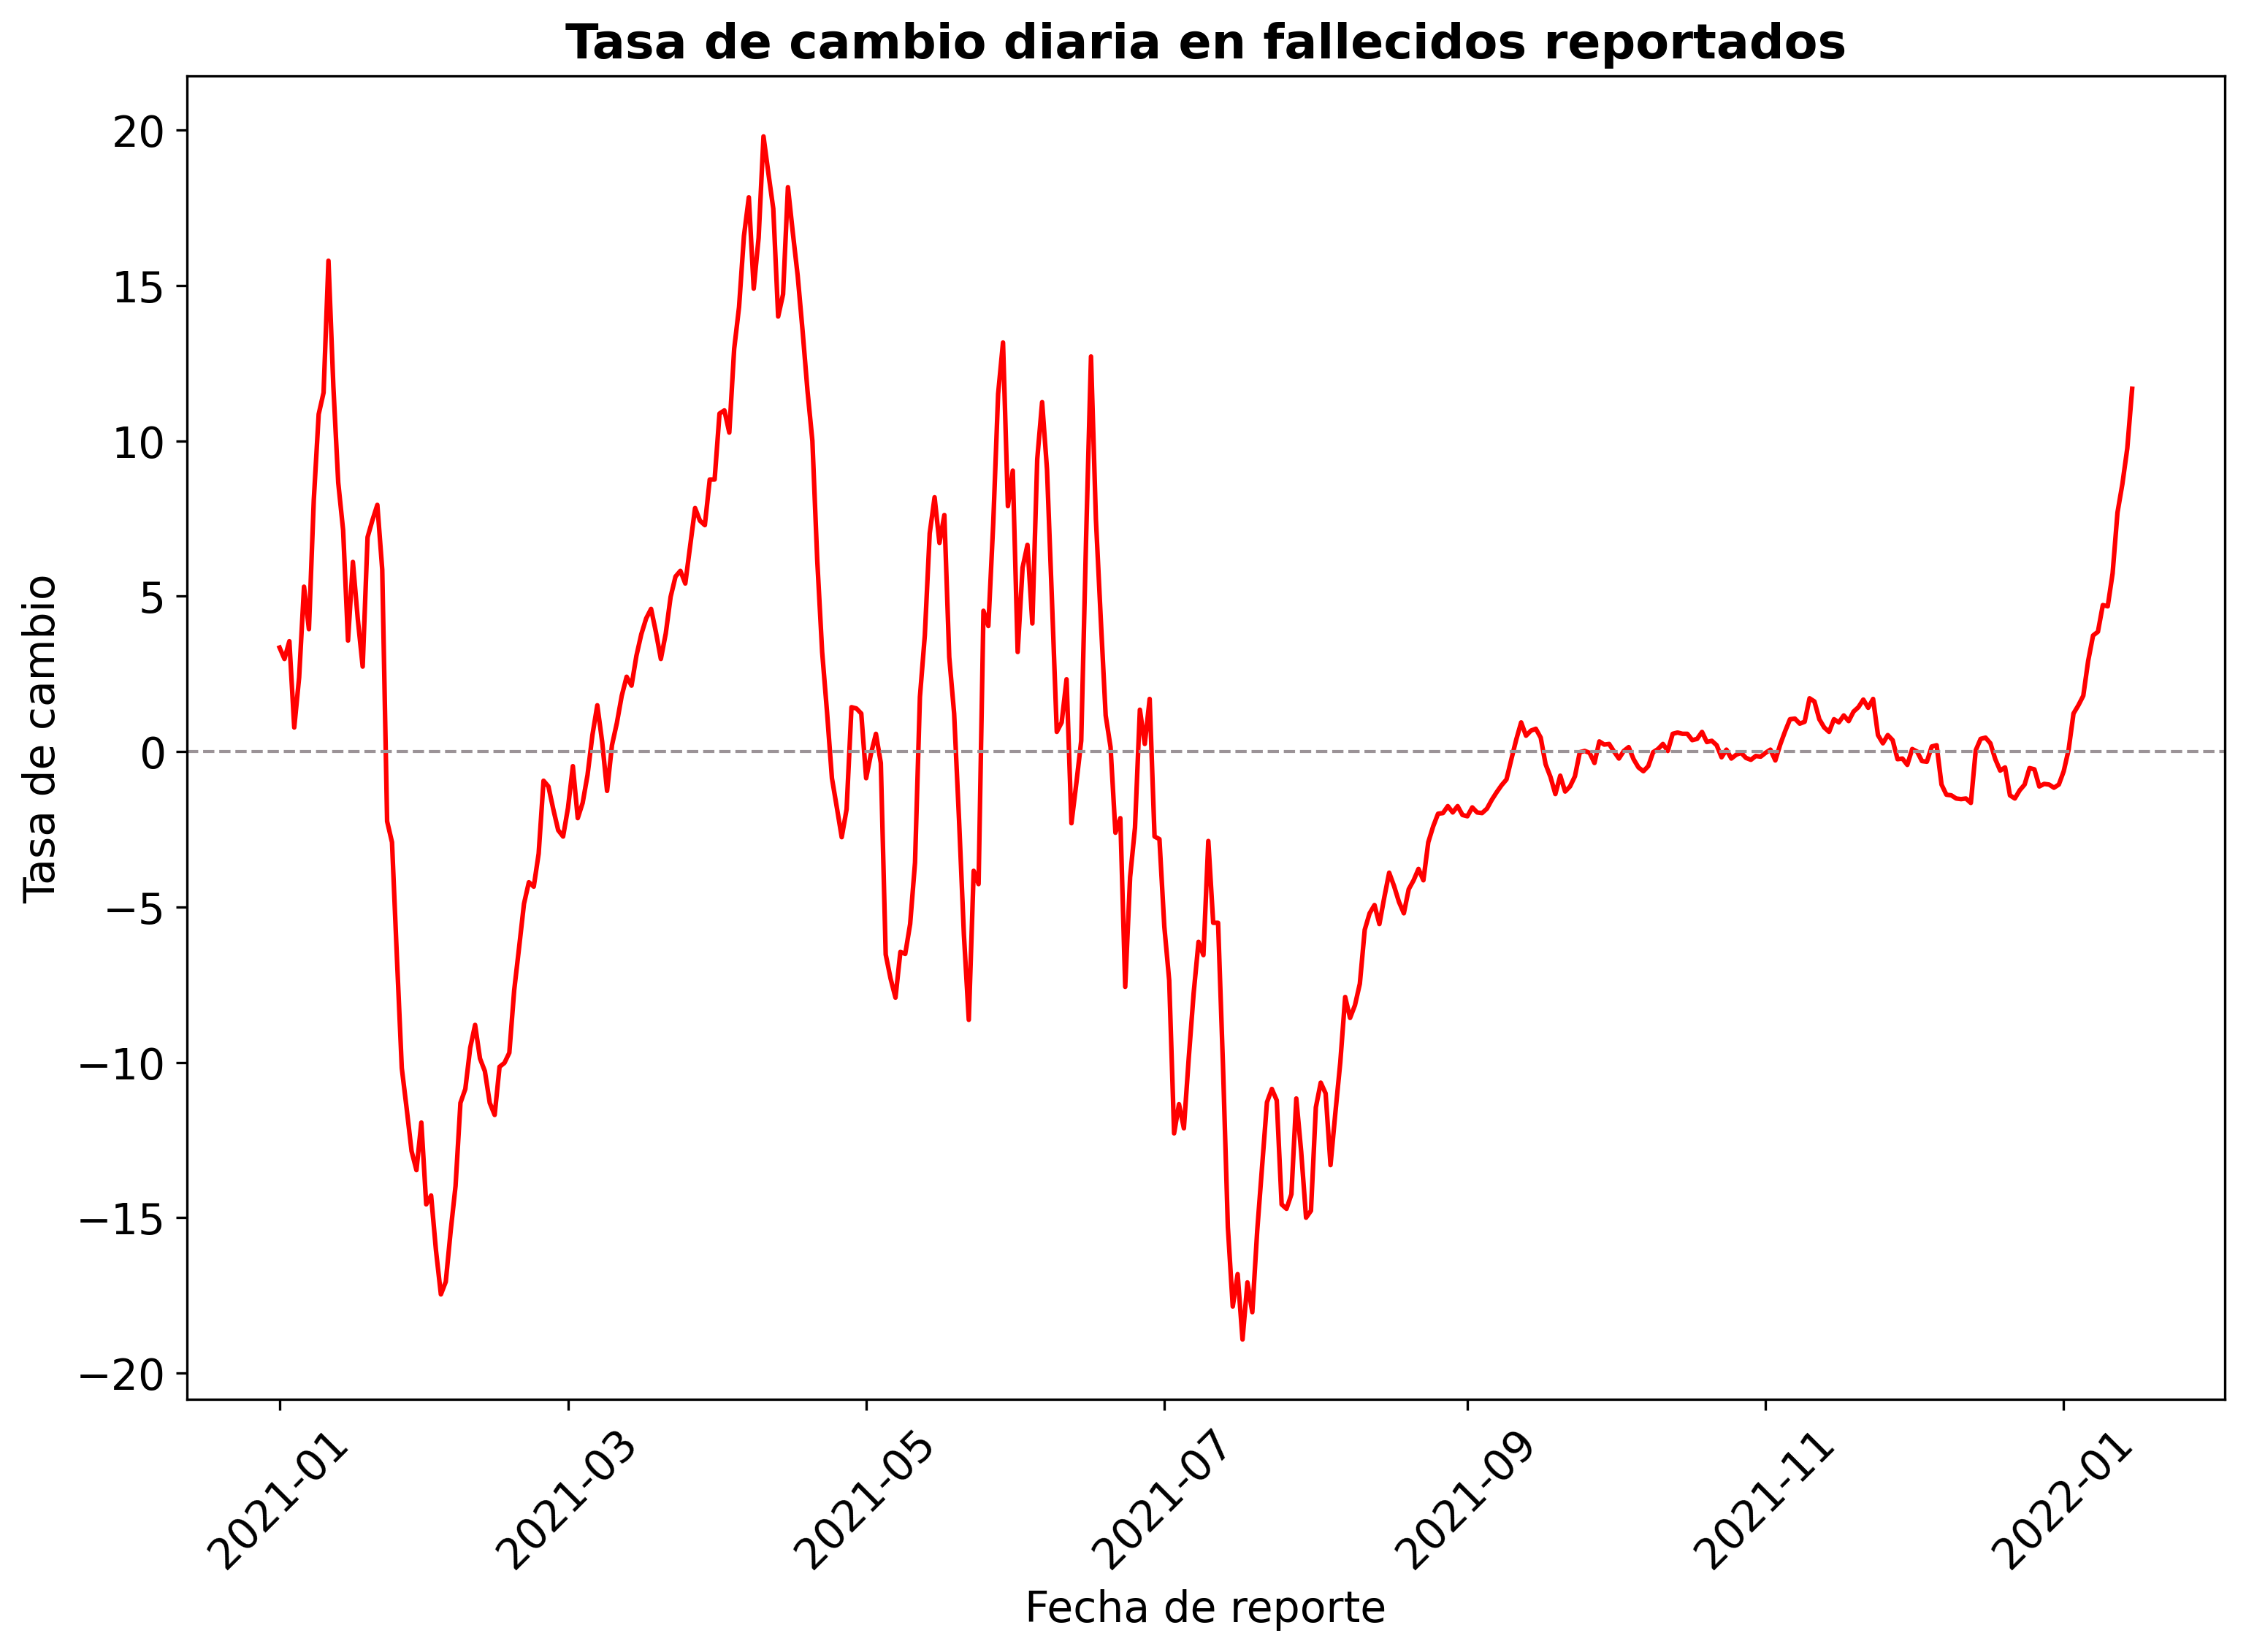

In [20]:
#%% PLOT Split fecha_recuperado_wev: FALLECIDOS
pico_tres = plt.figure(figsize=(12,8), dpi=300)
pico_tres = sns.lineplot(x="fecha_reporte_web", y="tcambio_pm", data=post_fallecidos, color="r")
pico_tres.axhline(0, ls="--", linewidth=1, color="#9B9397")
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Tasa de cambio", fontsize=14)
plt.xlabel("Fecha de reporte", fontsize=14)
plt.title("Tasa de cambio diaria en fallecidos reportados", fontweight="bold", fontsize=16)
plt.show()

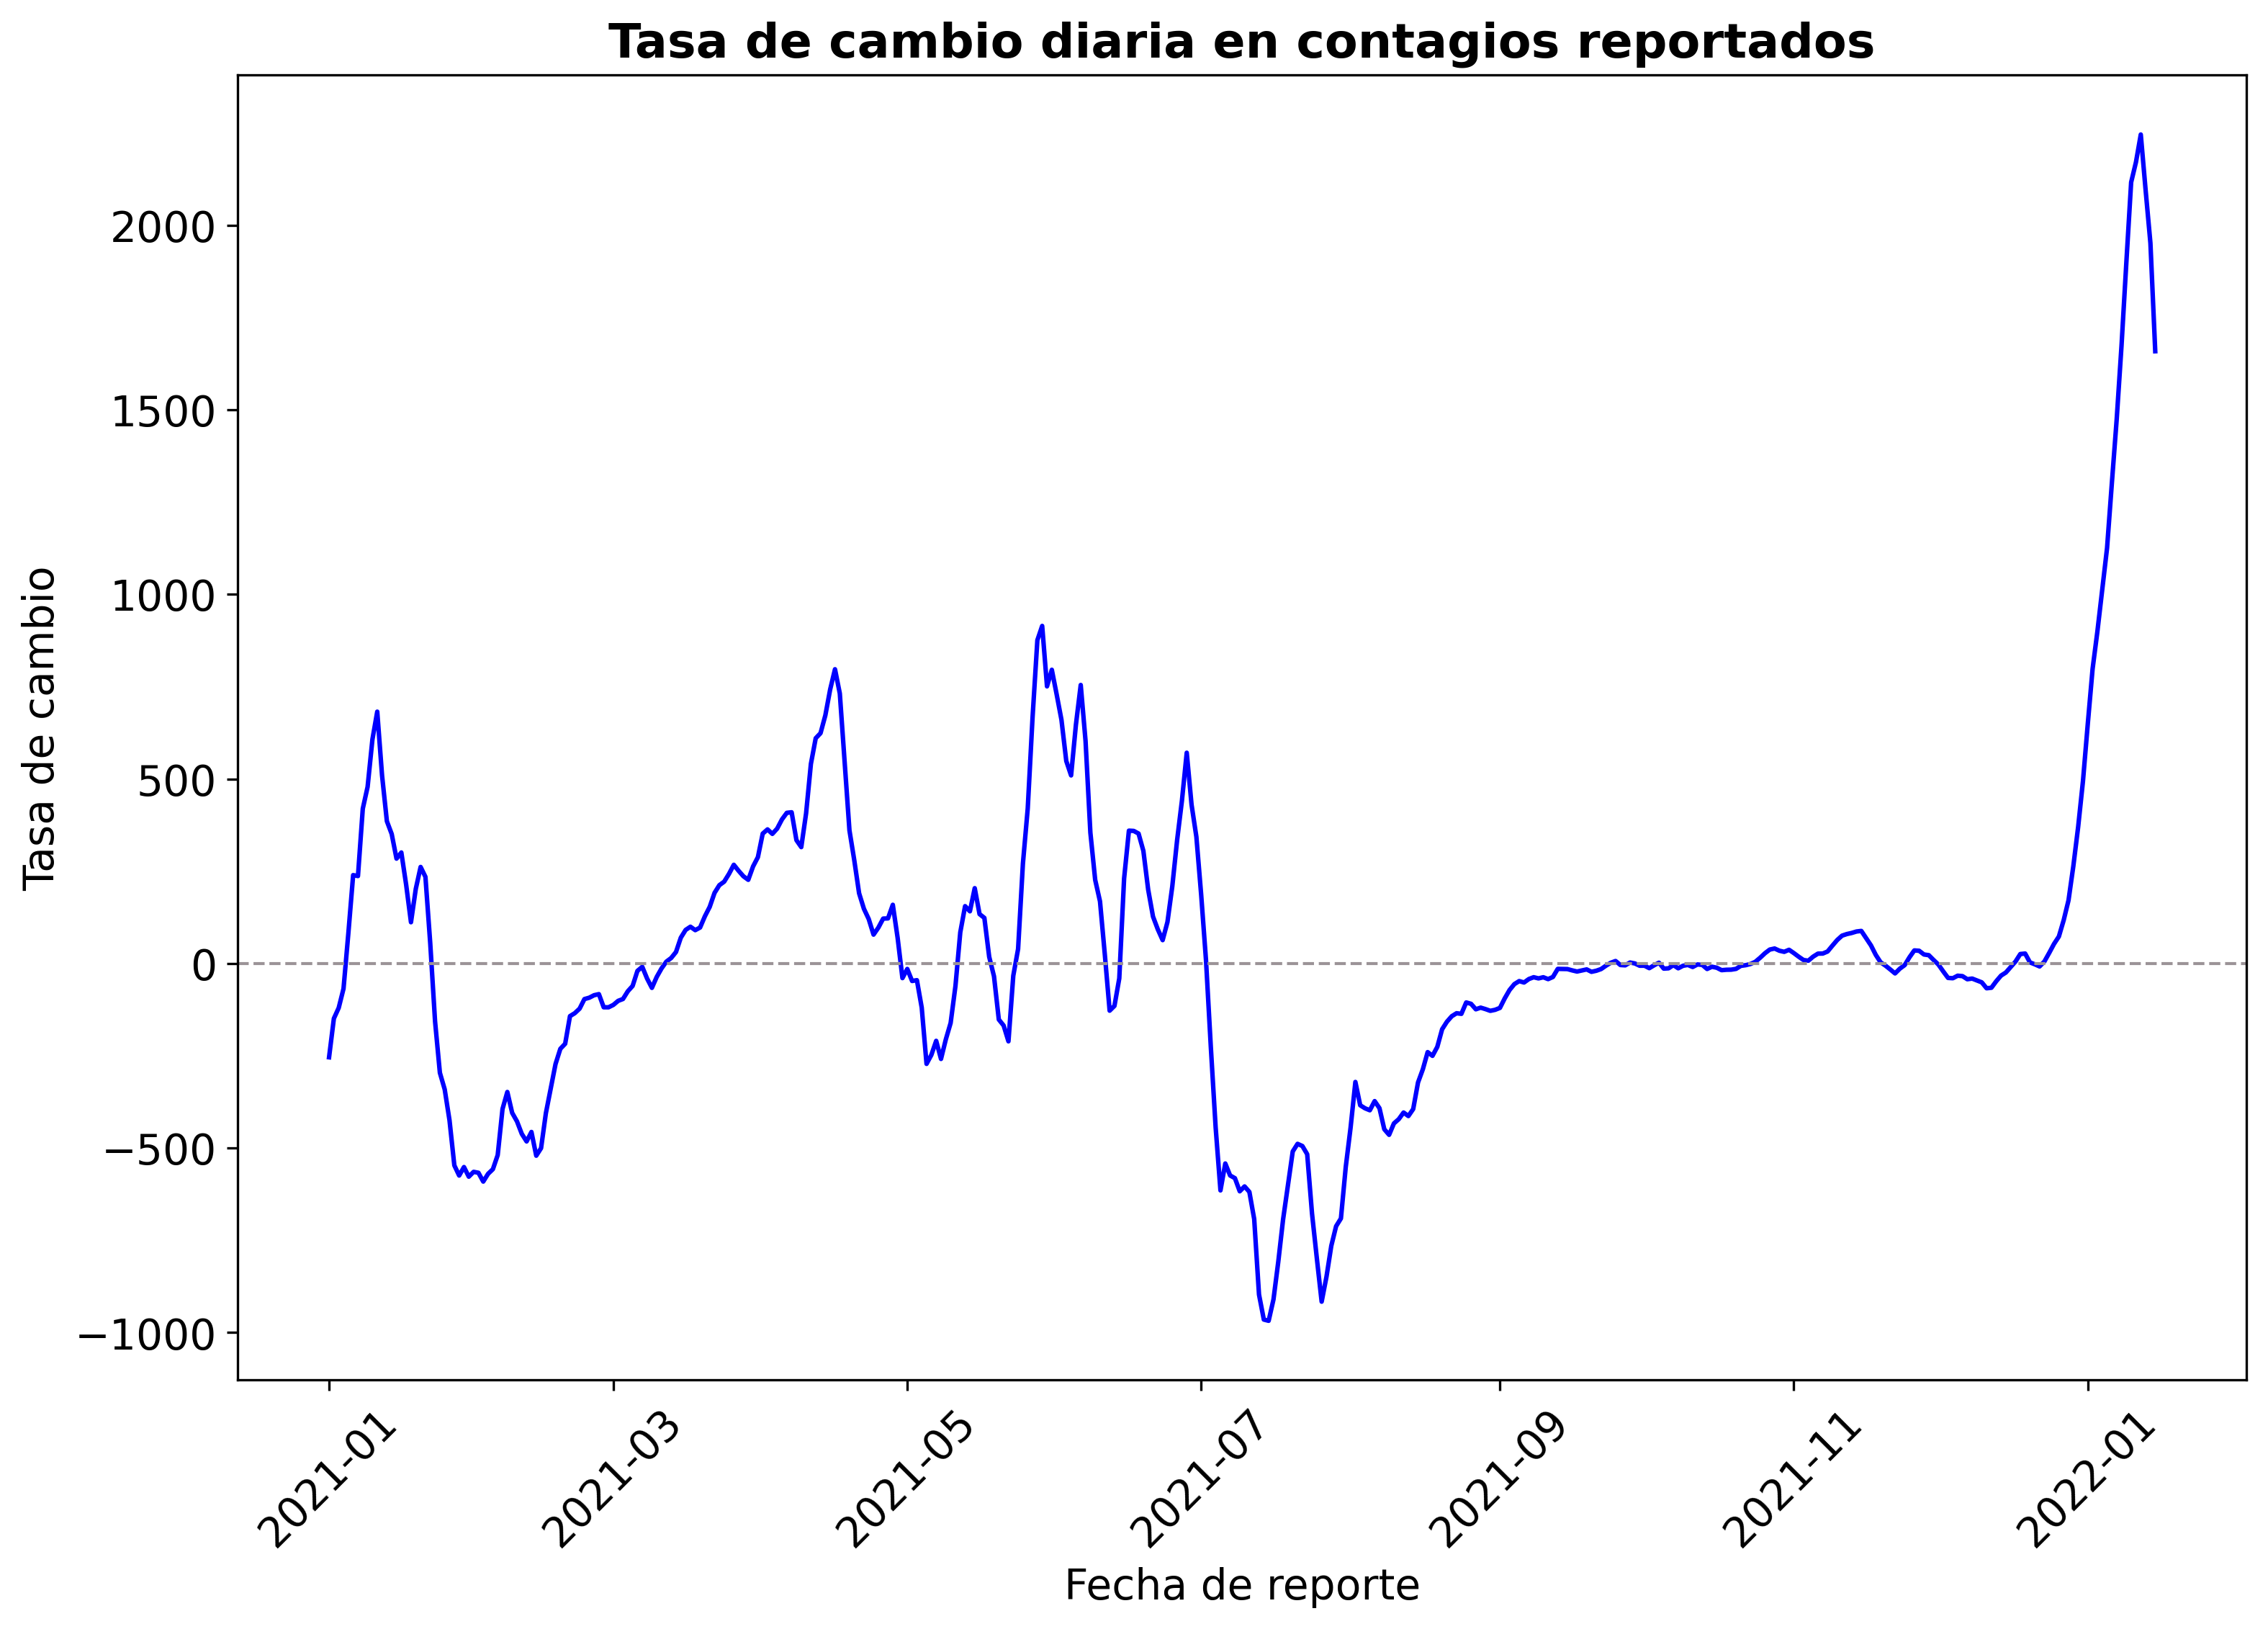

In [21]:
#%% PLOT Split fecha_recuperado_wev: CONTAGIOS
pico_tres = plt.figure(figsize=(12,8), dpi=300)
pico_tres = sns.lineplot(x="fecha_reporte_web", y="tcambio_pm", data=post_tercerpico, color="b")
pico_tres.axhline(0, ls="--", linewidth=1, color="#9B9397")
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Tasa de cambio", fontsize=14)
plt.xlabel("Fecha de reporte", fontsize=14)
plt.title("Tasa de cambio diaria en contagios reportados", fontweight="bold", fontsize=16)
plt.show()

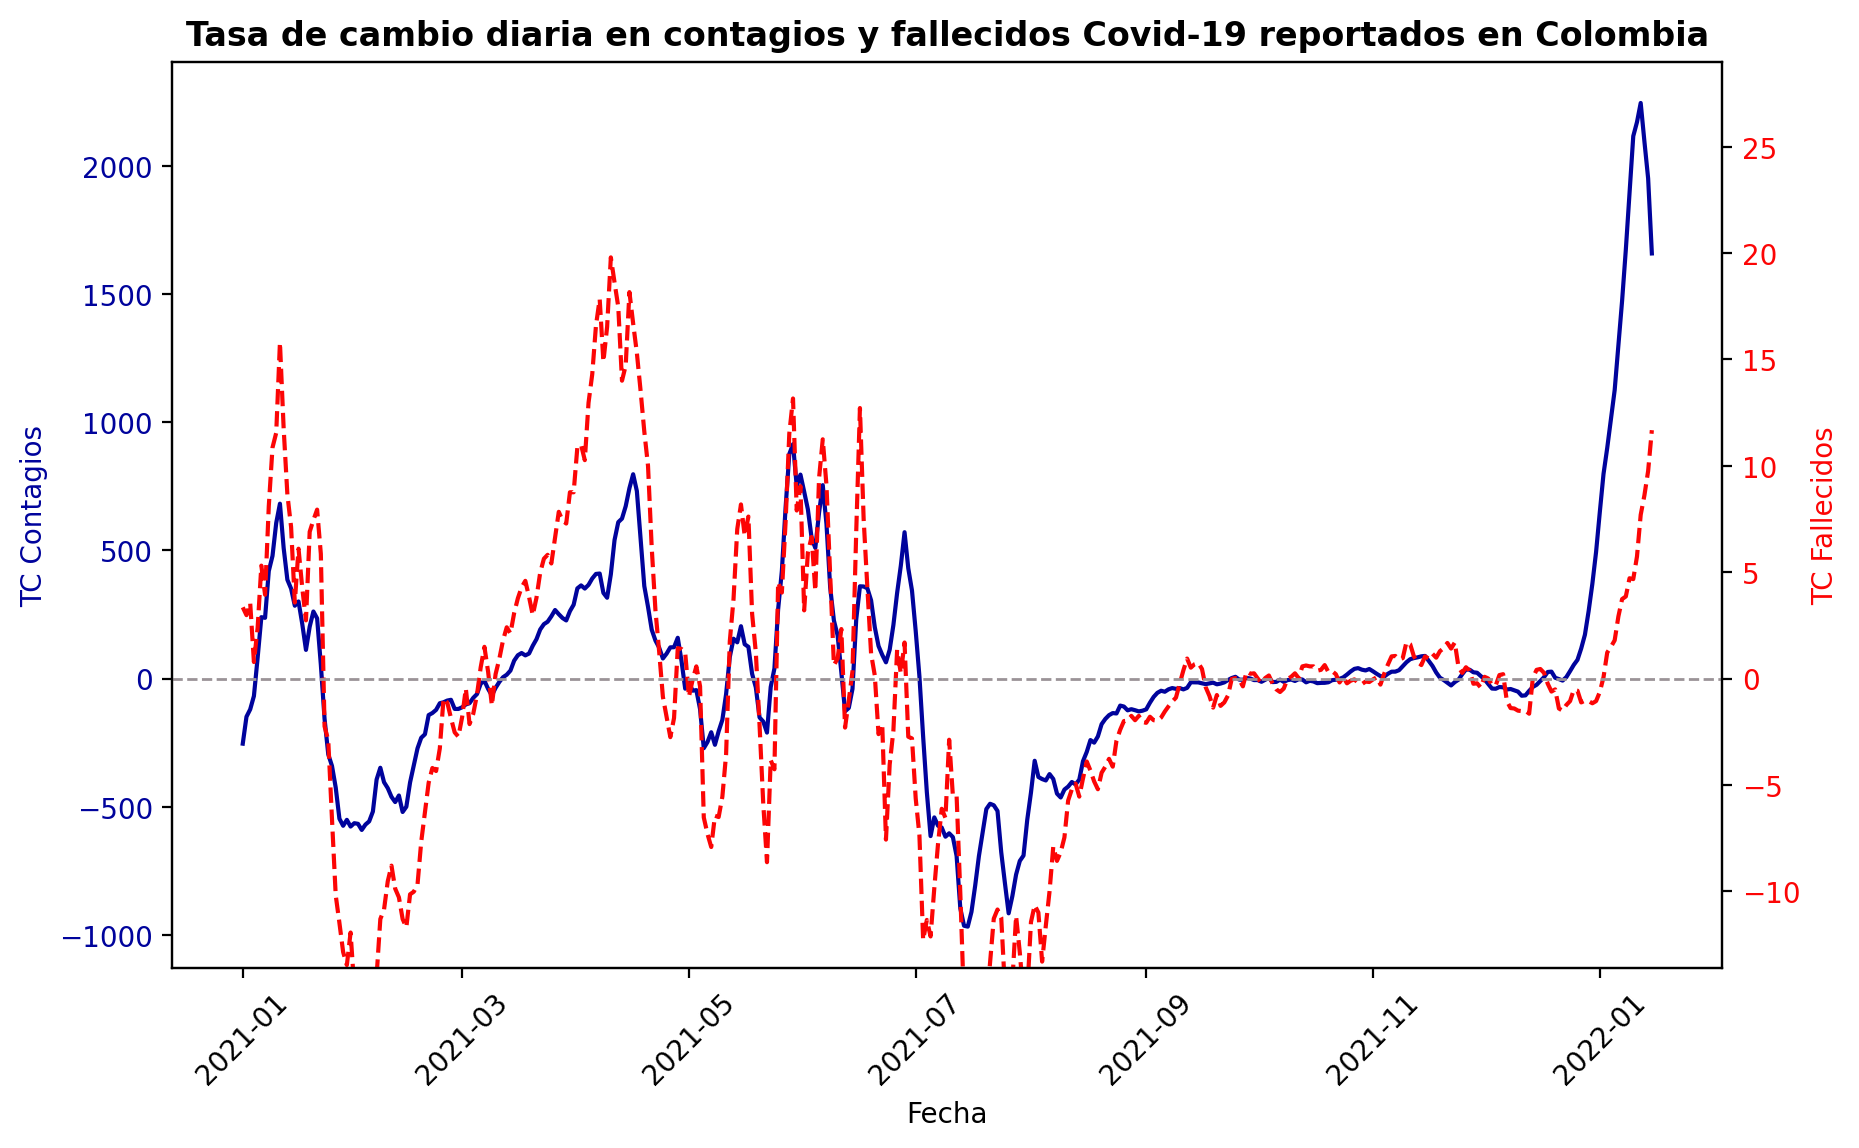

In [22]:
#%% Combinada de PLOT split tasa de cambio diaria 
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    
fig, ax1 = plt.subplots(figsize=(10,6), dpi=200)
#Plot bars and set
ax1.plot(post_tercerpico["fecha_reporte_web"], post_tercerpico["tcambio_pm"], "#00039c")
ax1.set_xlabel('Fecha')
plt.xticks(rotation=45)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('TC Contagios', color='#00039c')
[tl.set_color('#00039c') for tl in ax1.get_yticklabels()]
#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(post_fallecidos["fecha_reporte_web"], post_fallecidos["tcambio_pm"], '#fc0505',linestyle="--")
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('TC Fallecidos', color='#fc0505')
[tl.set_color('#fc0505') for tl in ax2.get_yticklabels()]
plt.title("Tasa de cambio diaria en contagios y fallecidos Covid-19 reportados en Colombia", fontweight="bold")
ax2.axhline(0, ls="--", linewidth=1, color="#9B9397")
align_yaxis(ax1, 0, ax2, 0)
plt.show()

<Figure size 432x288 with 0 Axes>

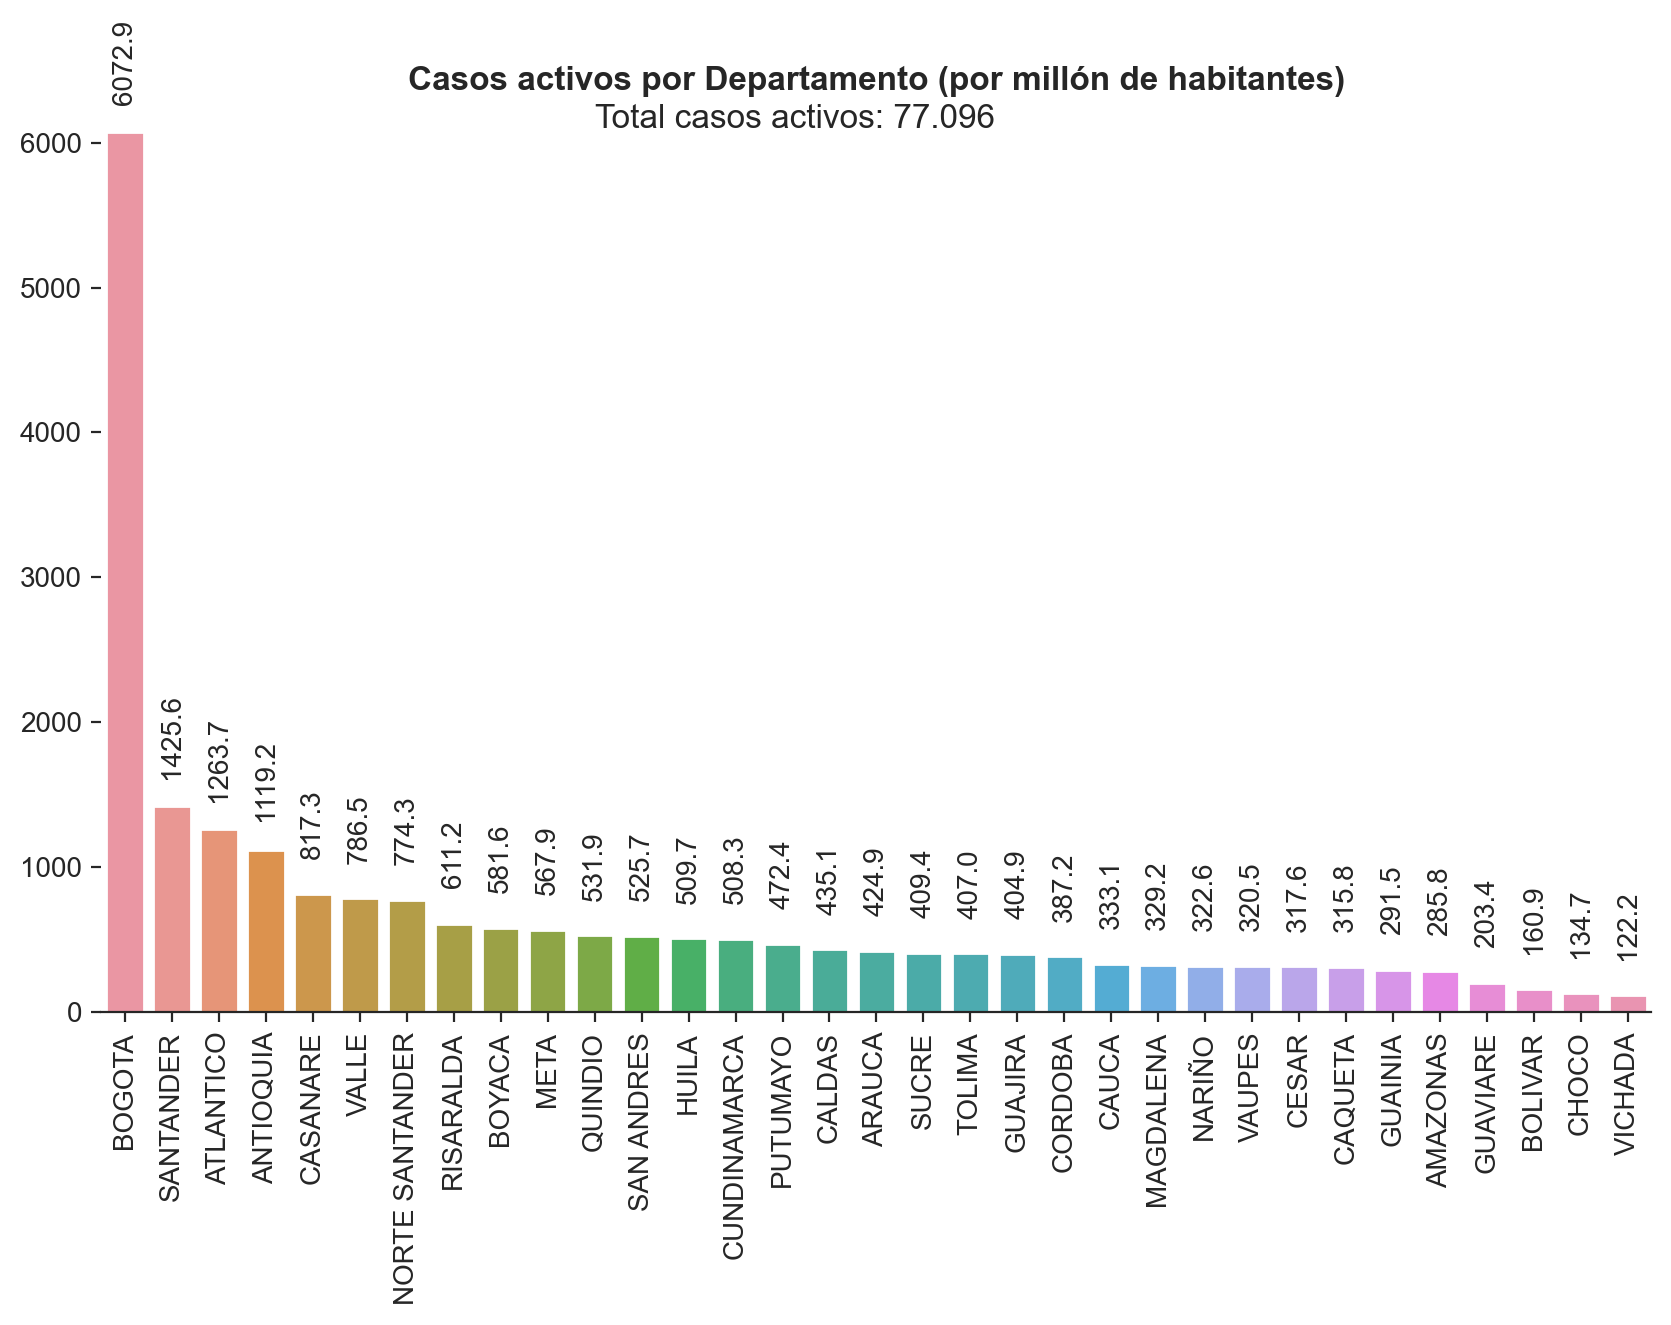

In [47]:
#%% LINEPLOT Promedio de edad de muerte a través del tiempo
palette = {"F":"#35DFBB", "M":"#357DDF"}
dpr = sns.lineplot(x="fecha_reporte_web", y="media muerte edad pm7d", data=resumen, palette=palette, linewidth=1)

"""Iteramos sobre las barras una por una
Función para llamar anotaciones sobre las barras.
Función inactiva por el momento"""

for bar in dpr.patches:
    dpr.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                   bar.get_height()), ha='center', va='center',
    size=9, xytext=(15, 5), #inicialmente en (0,5)
    textcoords='offset points')
# Ajustamos plot
plt.ylim(50, 80)
plt.xticks(rotation=45)
plt.ylabel("Edad")
plt.xlabel("Fecha reporte web")
plt.title("Comportamiento en el promedio de edad de muerte Covid-19", fontweight="bold", fontsize=10)
plt.clf()

#%% Countplot casos activos
plt.figure(figsize=(10,6), dpi=200)
act_count = sns.barplot(x="departamento_nom", y="tasa", data=activos_tasa)
act_count_mod = sns.despine(top=True, left=True)
plt.title("Casos activos por Departamento (por millón de habitantes)", fontsize=12, fontweight="bold")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0,6250)
plt.xlabel(None)
plt.ylabel(None)

for bar in act_count.patches:
    act_count.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                   bar.get_height()), ha='center', va='center', rotation=90,
    size=10, xytext=(0, 25), #inicialmente en (0,5)
    textcoords='offset points')
    
plt.annotate("Total casos activos: 77.096", xy=(10,6100), backgroundcolor="white", fontsize=12)
plt.show()

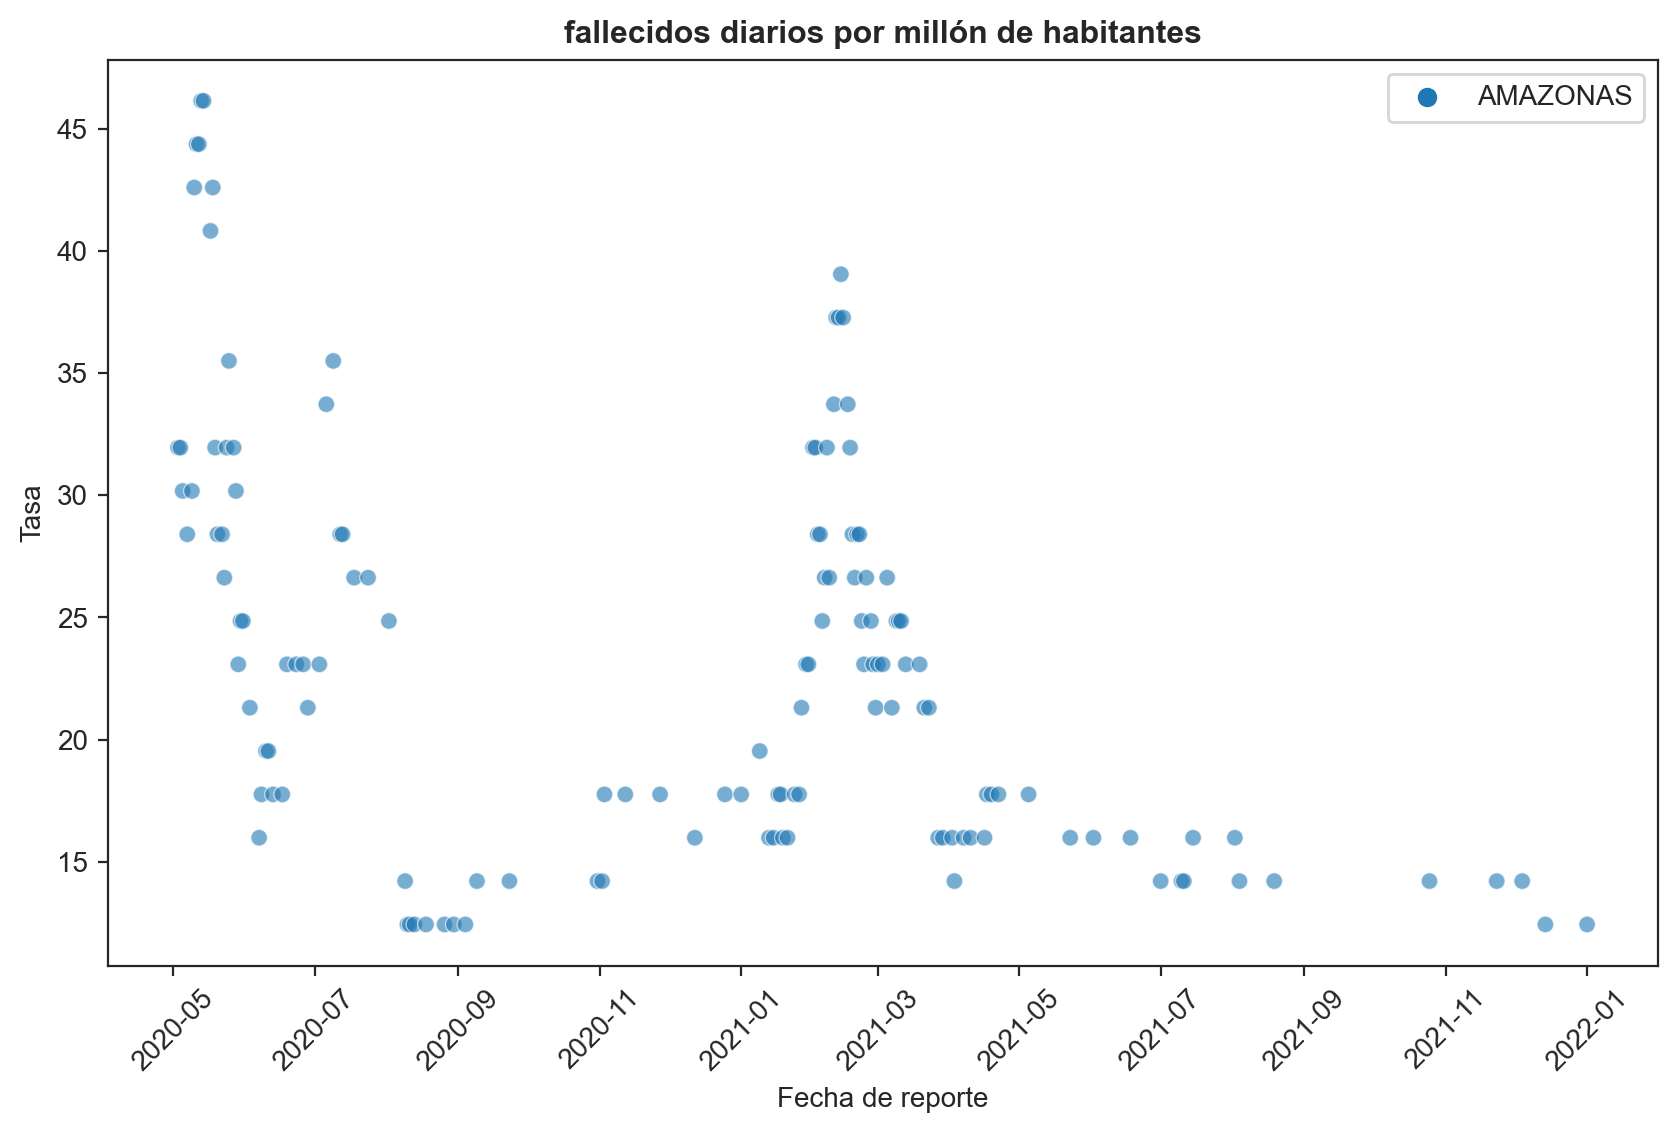

In [46]:
#%% Plot de casos por millón de habitantes
plt.figure(figsize=(10,6), dpi=200)
casos_millon = sns.scatterplot(x="fecha_reporte_web", y="tasa_millon_pm", data=highlighted_muerte , color="#e38a17", alpha=0.6, hue="departamento_nom") ##4493DD para los casos|#e38a17 para muertes
plt.xticks(rotation=45)
plt.title("fallecidos diarios por millón de habitantes", fontweight="bold", fontsize=11.5)
plt.xlabel("Fecha de reporte")
plt.ylabel("Tasa")
plt.legend()
plt.show()

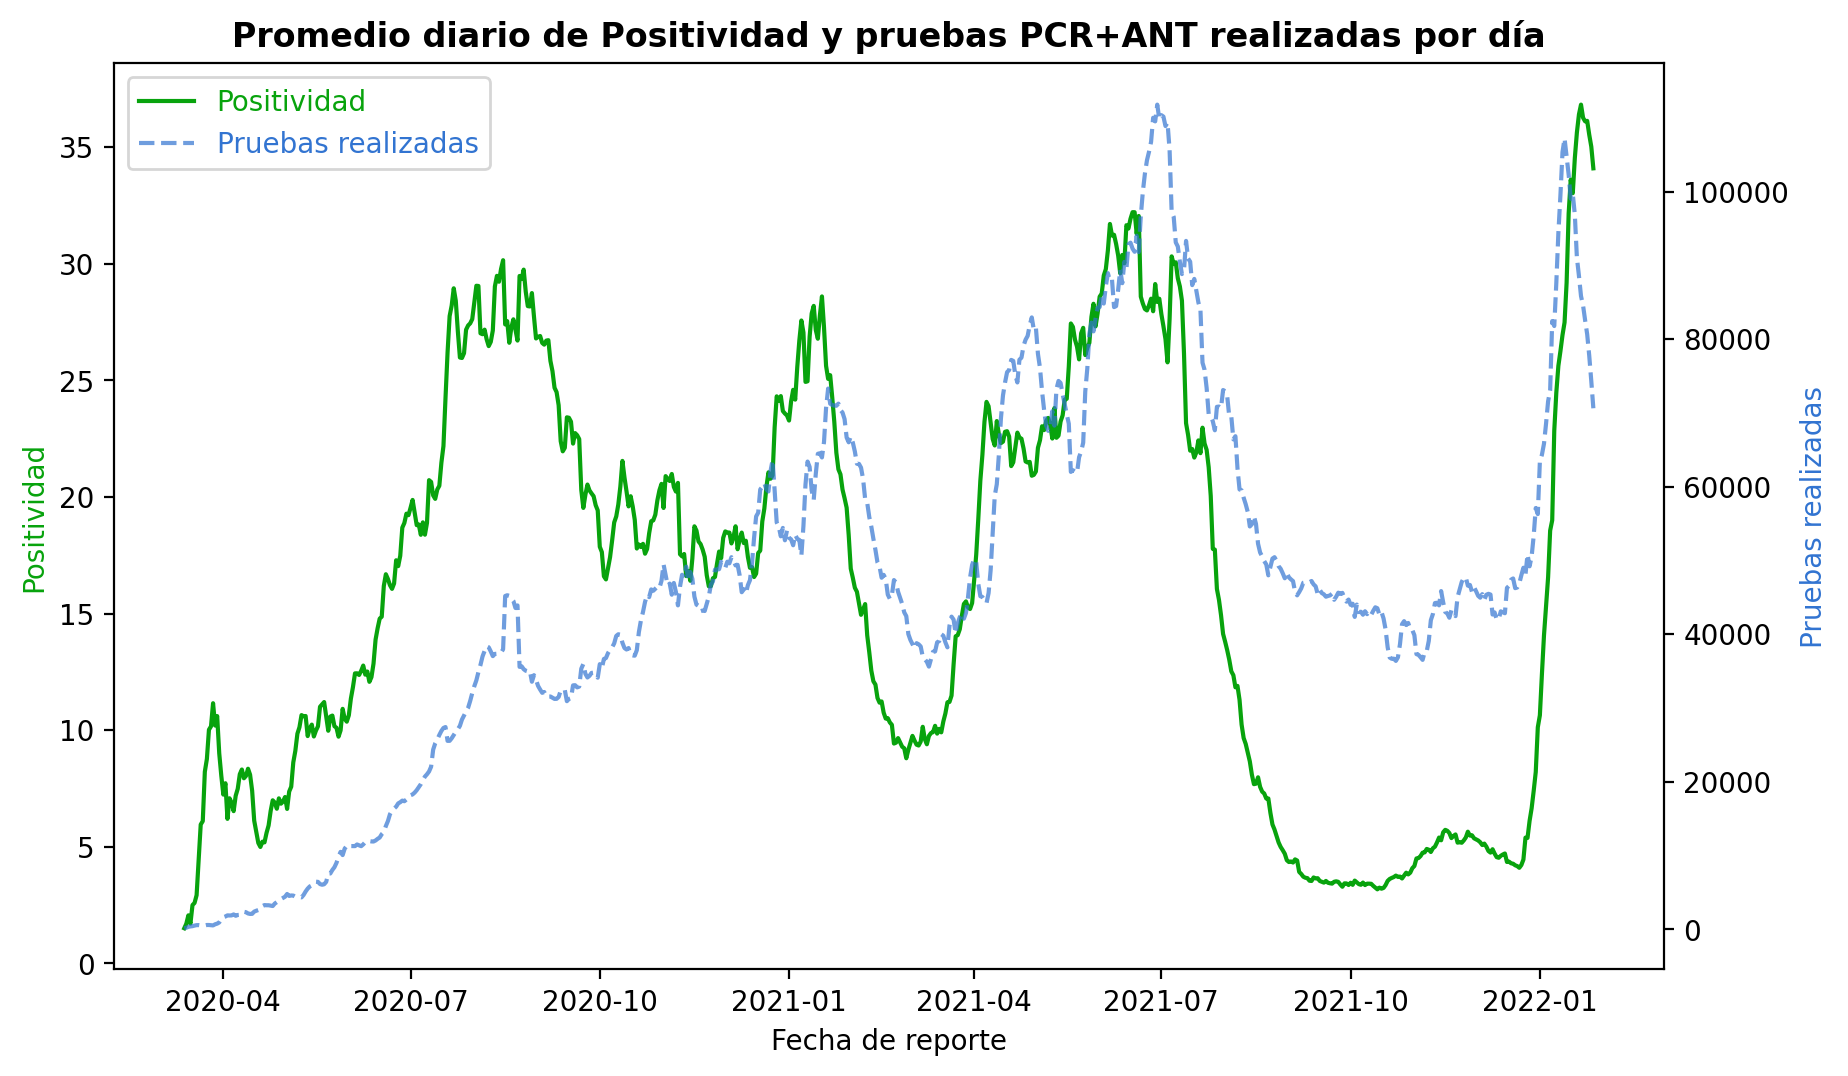

In [25]:
#%% PLOT DE excel_diario: positividad promedio ALTERNATIVA 1
plt.figure(figsize=(10,6), dpi=200)
host = host_subplot(111)
par = host.twinx()

host.set_xlabel("Fecha de reporte")
host.set_ylabel("Positividad")
par.set_ylabel("Pruebas realizadas")

p1, = host.plot(excel_diario["Fecha"], excel_diario["Positividad media"], label="Positividad", color="#08a30d")
p2, = par.plot(excel_diario["Fecha"], excel_diario["Pruebas suavizadas"], label="Pruebas realizadas", color="#3274d1", linestyle='dashed', alpha=.7)
leg = plt.legend()
host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())
plt.title("Promedio diario de Positividad y pruebas PCR+ANT realizadas por día", fontweight="bold")
plt.show()

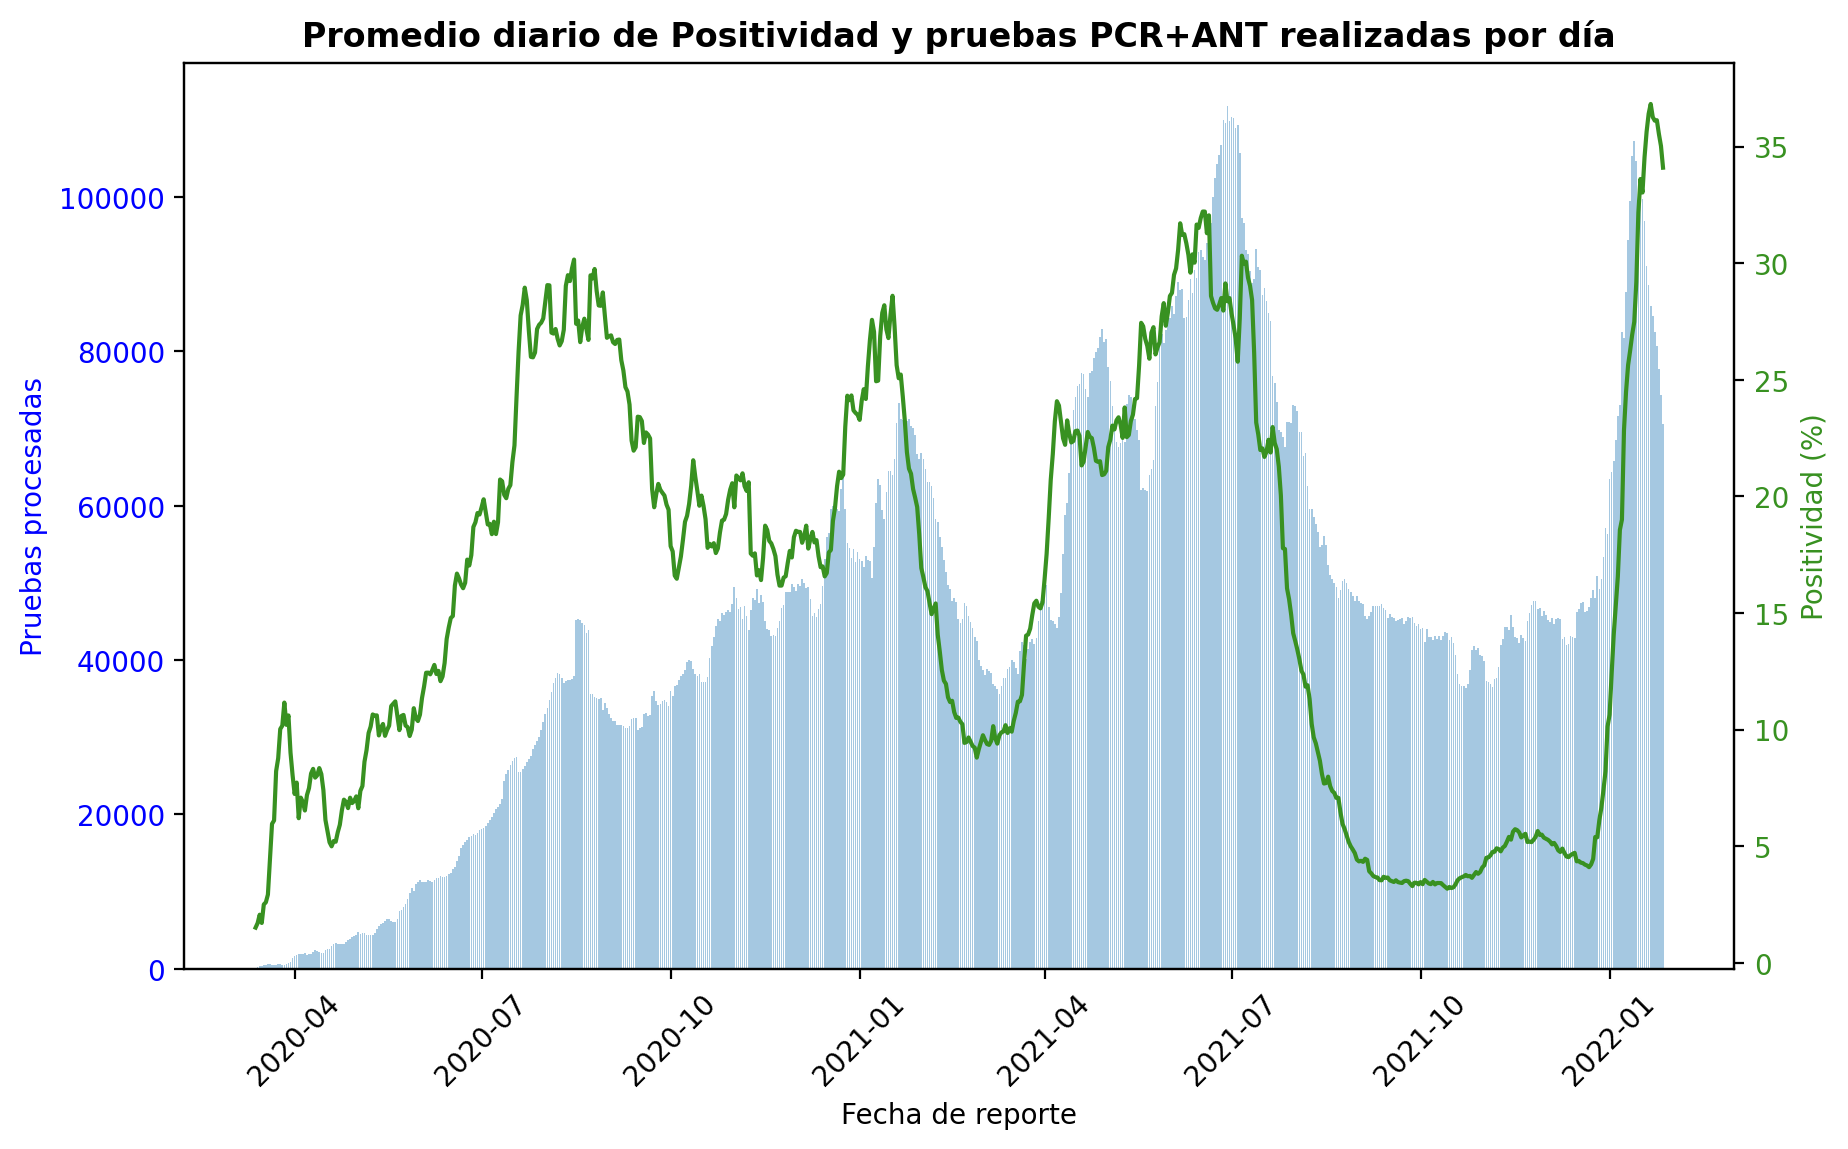

In [26]:
#%% PLOT DE excel_diario: positividad promedio ALTERNATIVA 2
#Plot graph with 2 y axes
fig, ax1 = plt.subplots(figsize=(10,6), dpi=200)
#Plot bars and set
ax1.bar(excel_diario["Fecha"], excel_diario["Pruebas suavizadas"], alpha=0.4)
ax1.set_xlabel('Fecha de reporte')
plt.xticks(rotation=45)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Pruebas procesadas', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]
#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(excel_diario["Fecha"], excel_diario["Positividad media"], '#389121')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Positividad (%)', color='#389121')
[tl.set_color('#389121') for tl in ax2.get_yticklabels()]
plt.title("Promedio diario de Positividad y pruebas PCR+ANT realizadas por día", fontweight="bold")
plt.show()

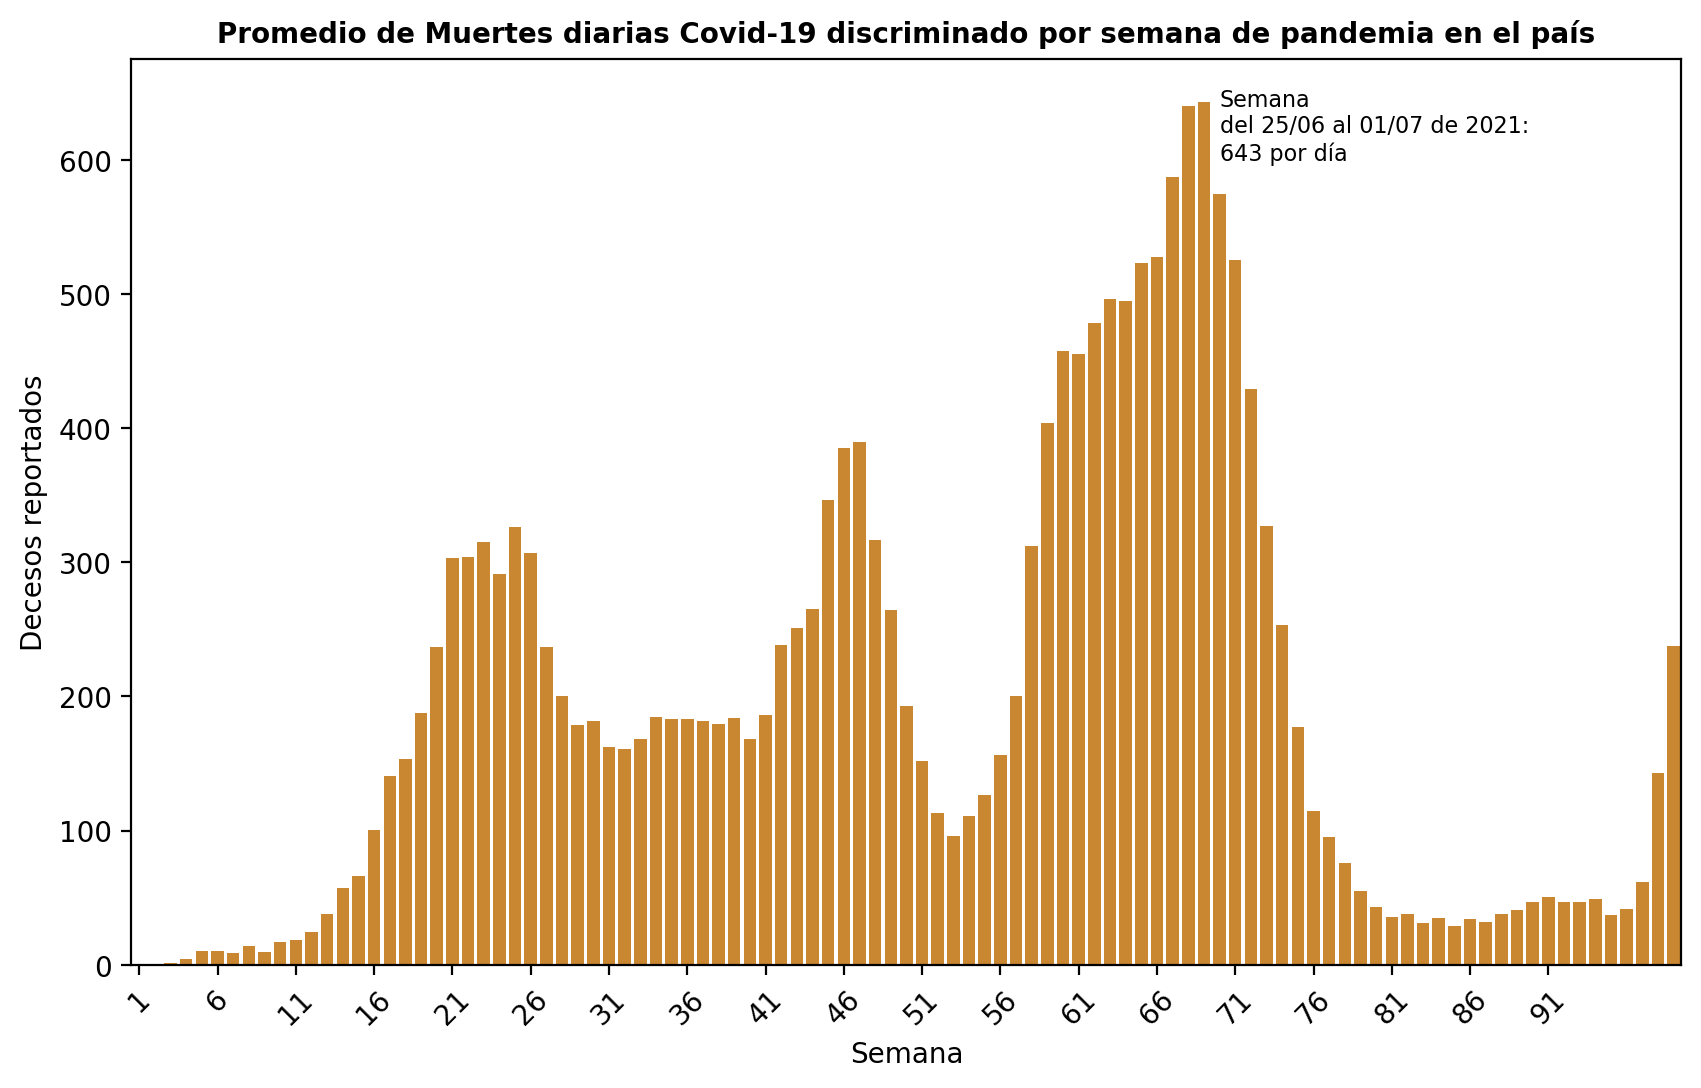

In [27]:
#%% DataFrame SEMANAL de casos y muertes
semanal = excel_diario.groupby(["Sem"])[["Casos", "FALLECIDOS"]].mean()
semanal = semanal.reset_index()
plt.figure(figsize=(10,6), dpi=200)
sns.barplot(x="Sem", y="FALLECIDOS", data=semanal, color="#e38a17")
plt.xticks(rotation=45)
plt.ylabel("Decesos reportados")
plt.xlabel("Semana")
plt.title("Promedio de Muertes diarias Covid-19 discriminado por semana de pandemia en el país", fontweight="bold", fontsize=10)
plt.xticks(np.arange(0, 93, step=5))
text = plt.annotate("Semana\ndel 25/06 al 01/07 de 2021:\n643 por día", (69,600))
text.set_fontsize(8)
plt.show()